In [42]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [43]:
path = untar_data(URLs.MNIST)
Path.BASE_PATH = path

In [45]:
path

Path('.')

In [4]:
def get_dls(bs=64):
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
        get_items=get_image_files, 
        splitter=GrandparentSplitter('training','testing'),
        get_y=parent_label,
        batch_tfms=Normalize()
    ).dataloaders(path, bs=bs)

dls = get_dls()

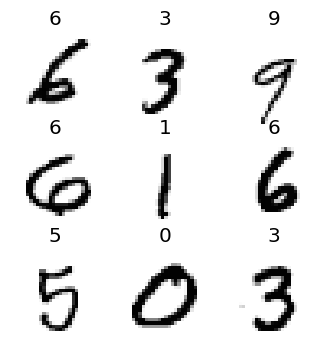

In [5]:
dls.show_batch(max_n=9, figsize=(4,4))

In [7]:
def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    if act: layers.append(nn.ReLU())
    layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)
    
def simple_cnn():
    return sequential(
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        Flatten(),
    )

def fit(epochs=1, lr=0.06):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, lr)
    return learn

In [8]:
learn = fit(5, lr=0.1)

/home/ilua/miniconda3/lib/python3.11/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.144561,0.088753,0.971500,00:22
1,0.090877,0.075779,0.976200,00:17
2,0.070644,0.047167,0.986100,00:18
3,0.038402,0.035769,0.988900,00:18
4,0.021992,0.027043,0.992600,00:19


In [20]:
list(learn.model.children())

[Sequential(
   (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
   (1): ReLU()
   (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 ),
 Sequential(
   (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): ReLU()
   (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 ),
 Sequential(
   (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): ReLU()
   (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 ),
 Sequential(
   (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): ReLU()
   (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 ),
 Sequential(
   (0): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 ),
 fastai.layers.Flatten(full=False)]

In [36]:
model_weights =[]
conv_layers = []

# get all the model children as list
model_children = list(learn.model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for child in list(model_children[i].children()):
            if type(child) == nn.Conv2d:
                counter+=1
                model_weights.append(child.weight)
                conv_layers.append(child)       

print(f"Total convolution layers: {counter}")
print("conv_layers")

Total convolution layers: 5
conv_layers


In [34]:
conv_layers

[Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)),
 Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
 Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
 Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
 Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))]

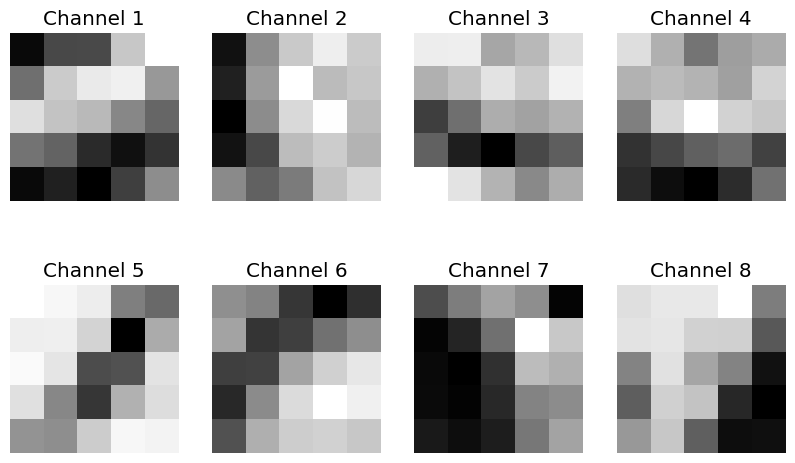

In [95]:
kernel_weights = conv_layers[0].weight
reshaped_image = kernel_weights.view(8, 5, 5)
reshaped_image_cpu = reshaped_image.to('cpu')
# Plot each channel (feature map) as a separate subplot
plt.figure(figsize=(10, 6))
for i in range(8):
    plt.subplot(2, 4, i + 1)  # 2 rows, 4 columns
    plt.imshow(reshaped_image_cpu[i, :, :].detach().numpy(), cmap='gray')  # Display the first channel
    plt.title(f"Channel {i + 1}")
    plt.axis('off')

plt.show()

In [98]:
# Access the kernel weights
kernel_weights = conv_layers[1].weight

print(kernel_weights.shape)
# Print the kernel weights
# print(kernel_weights)

torch.Size([16, 8, 3, 3])


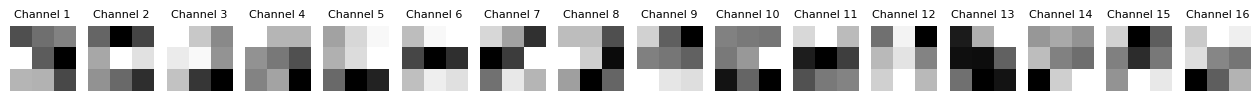

In [130]:
# Reshape the tensor to (8, 5, 5) for visualization
reshaped_image = kernel_weights.view(16, 8, 3, 3)
reshaped_image_cpu = reshaped_image.to('cpu')
# Plot each channel (feature map) as a separate subplot
plt.figure(figsize=(16, 6))
for i in range(16):
    plt.subplot(1, 16, i + 1)  # 4 rows, 4 columns
    # plt.subplot(16, 8, i * 8 + j + 1)  # 16 rows, 8 columns  /// HOW to subplots all pictures on 1 plot ? 
    plt.imshow(reshaped_image_cpu[i, 0, :, :].detach().numpy(), cmap='gray')  # Display the first channel
    plt.title(f"Channel {i + 1}" , fontsize=8)
    plt.axis('off')
    
plt.show()



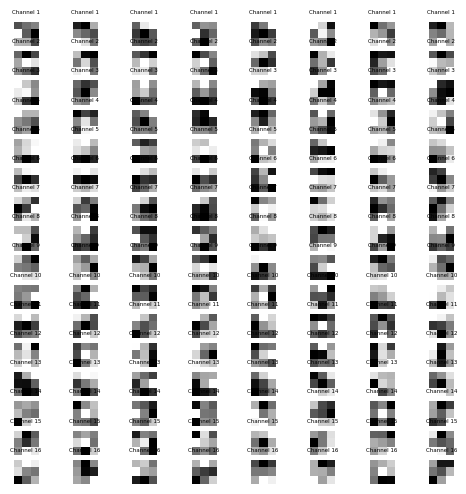

In [129]:
# Create a single large plot with a grid of subplots
fig, axs = plt.subplots(16, 8, figsize=(6, 6))

for i in range(16):
    for j in range(8):
        axs[i, j].imshow(reshaped_image_cpu[i, j, :, :].detach().numpy(), cmap='gray')
        axs[i, j].set_title(f"Channel {i + 1}", fontsize=4)
        axs[i, j].axis('off')

# plt.tight_layout()  # Adjust subplot spacing
plt.show()

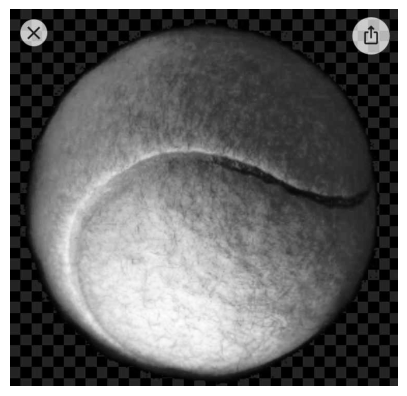

In [72]:
img = Image.open('/home/ilua/fastbook_week8_book13/sphere.jpg')
img_gray = img.convert('L')
show_image(img_gray);


In [73]:
from torchvision import models, transforms
# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# pretrained_model = pretrained_model.to(device)
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=0., std=1.)  # Normalize the image tensor
]) 
# Preprocess the image and move it to GPU
input_image = image_transform(img_gray)
input_image = input_image.unsqueeze(0)  # Add a batch dimension
input_image = input_image.to(device)
 
# Extract feature maps
feature_maps = []  # List to store feature maps
layer_names = []  # List to store layer names
for layer in conv_layers:
    input_image = layer(input_image)
    feature_maps.append(input_image)
    layer_names.append(str(layer))

In [74]:
# Display feature maps shapes
print("\nFeature maps shape")
for feature_map in feature_maps:
    print(feature_map.shape)
 
# Process and visualize feature maps
processed_feature_maps = []  # List to store processed feature maps
for feature_map in feature_maps:
    feature_map = feature_map.squeeze(0)  # Remove the batch dimension
    mean_feature_map = torch.sum(feature_map, 0) / feature_map.shape[0]  # Compute mean across channels
    processed_feature_maps.append(mean_feature_map.data.cpu().numpy())


Feature maps shape
torch.Size([1, 8, 112, 112])
torch.Size([1, 16, 56, 56])
torch.Size([1, 32, 28, 28])
torch.Size([1, 64, 14, 14])
torch.Size([1, 10, 7, 7])


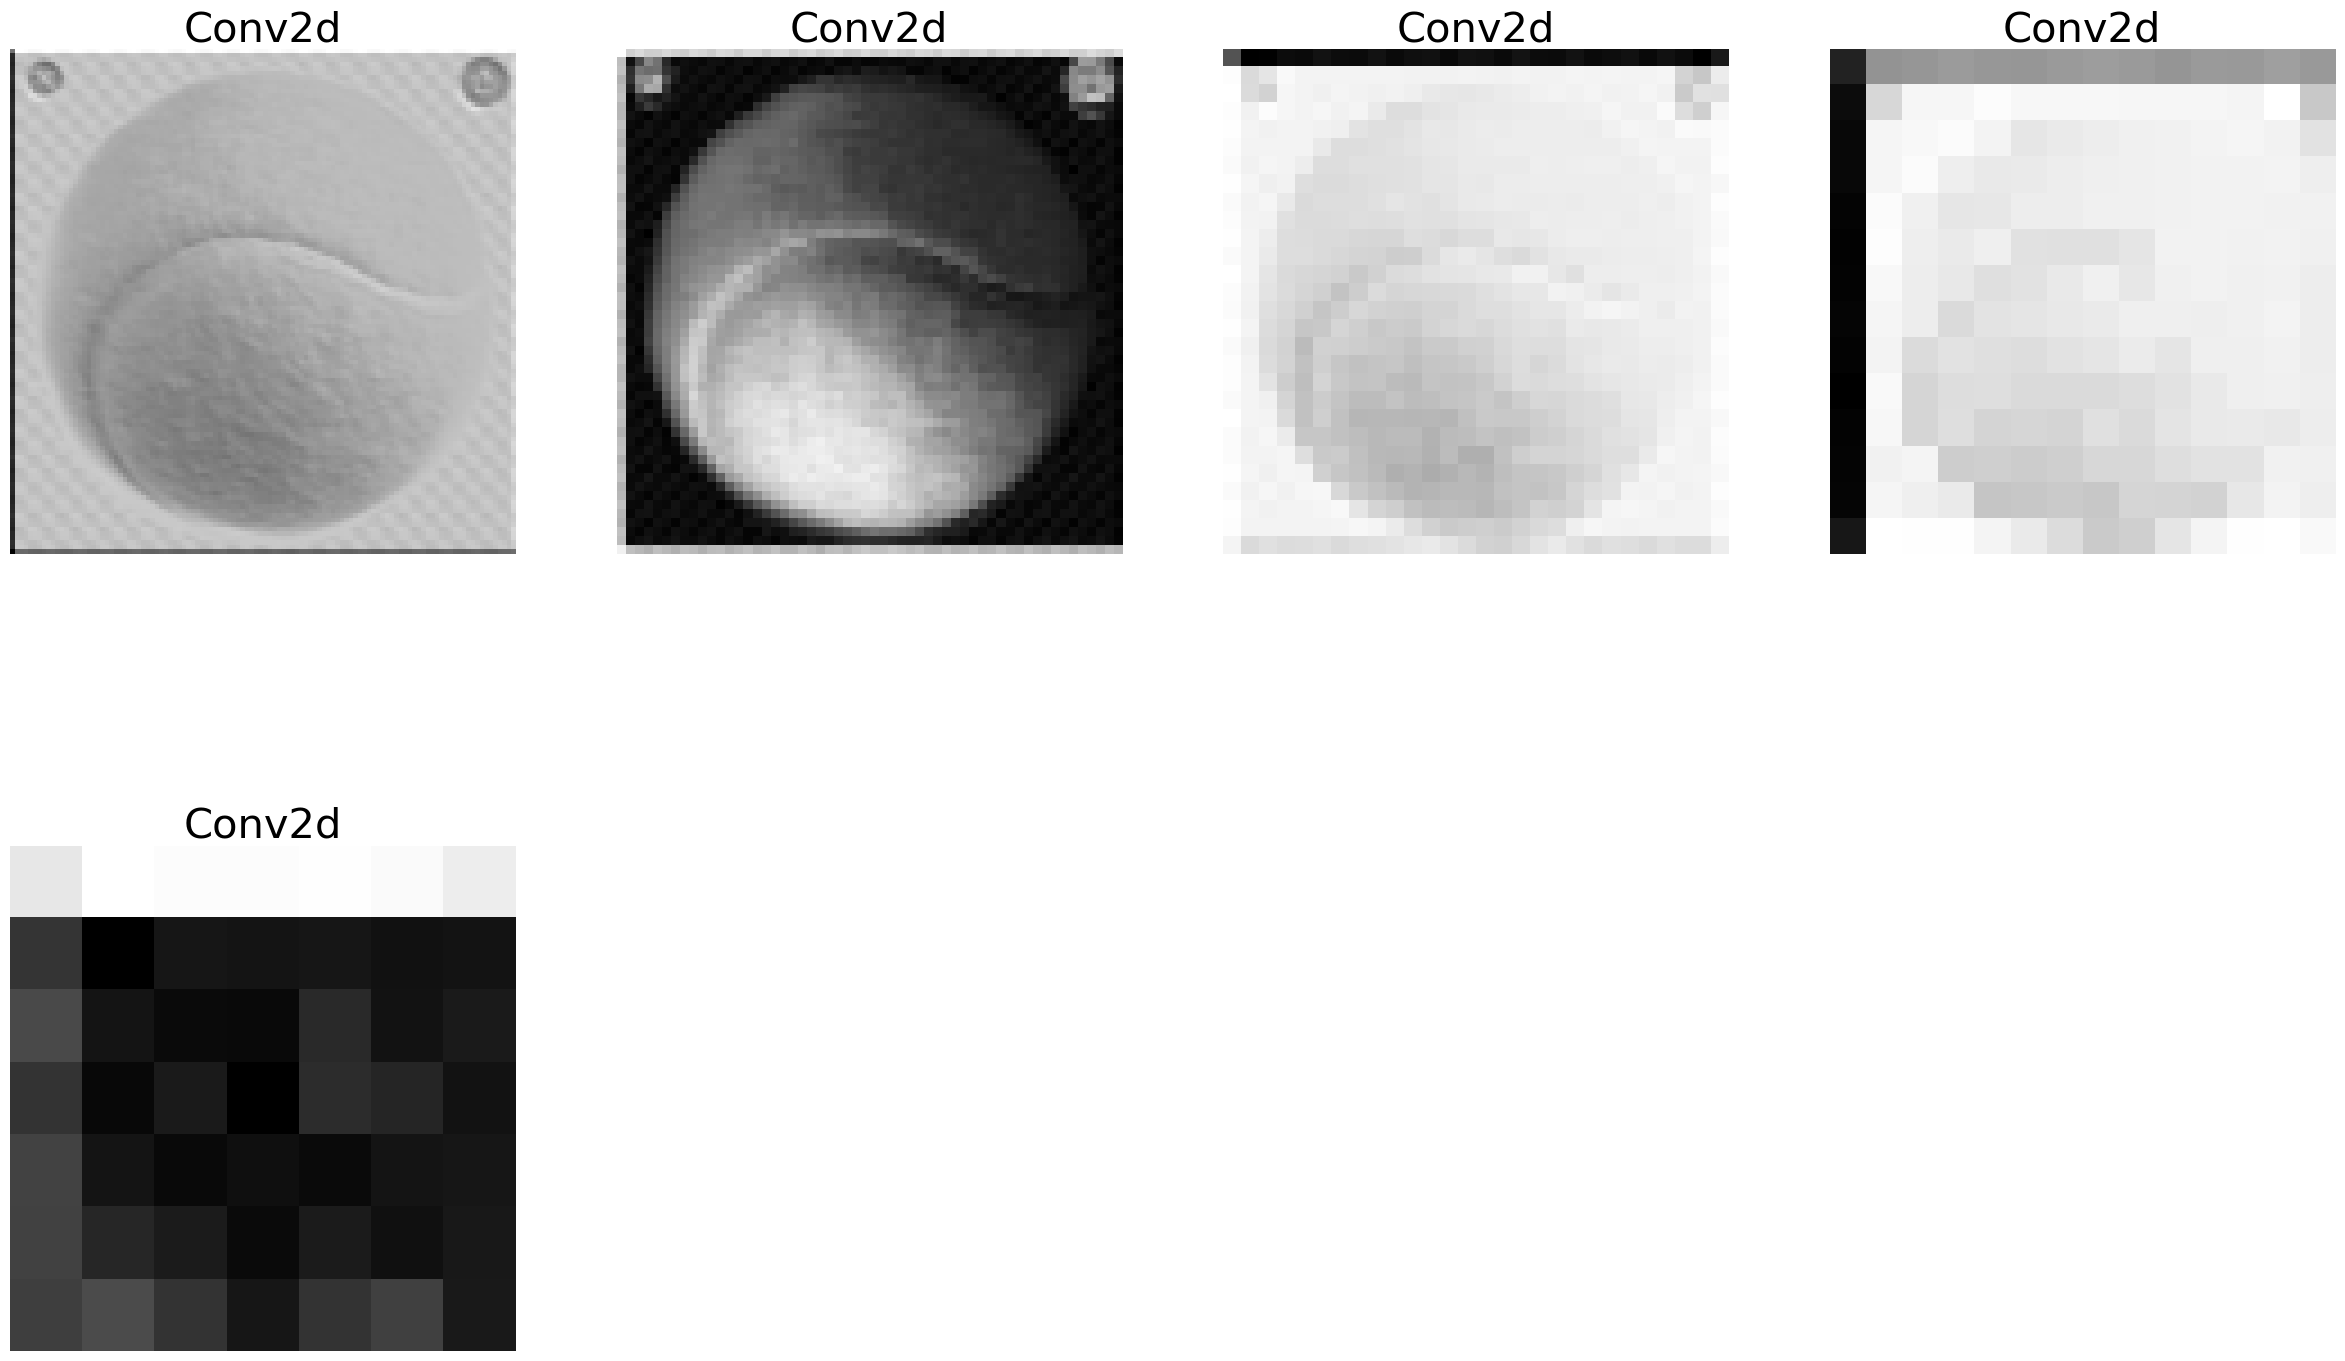

In [75]:
# Plot the feature maps
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed_feature_maps)):
    ax = fig.add_subplot(5, 4, i + 1)
    ax.imshow(processed_feature_maps[i])
    ax.axis("off")
    ax.set_title(layer_names[i].split('(')[0], fontsize=30)